# 电力窃漏电用户自动识别

## 挖掘目标

利用电力公司的自动化系统所采集到的各相电流、电压、功率因数等用电负荷数据以及用电异常等终端信息，提取出窃漏电用户的关键特征，构建识别模型，自动检查，判断用户是否存在窃漏电行为。

## 分析方法与过程

- 从电力计量自动化系统、营销系统有选择性地抽取部分大用户用电负荷、终端报警及违约窃电处罚信息等原始数据；
- 对样本数据探索分析，提出部分不可能存在窃电行为的用户，即白名单用户，初步审视正常用户和窃漏电用户的用电特征；
- 对样本数据进行预处理，包括数据清洗、缺失值处理和数据变换；
- 构建专家样本集；
- 构建窃漏电用户识别模型；
- 在线监测用户用电负荷及终端报警，调用模型实现实时诊断。

### 数据抽取

从营销系统抽取的数据：
- 用户基本信息：用户名称、用户编号、用电地址、用电类别、报表容量、计量方式、电流互感器变化、电压互感器变化
- 违约、窃电处理记录
- 计量方法及依据
从计量自动化系统采集的数据属性：
- 实时负荷：时间点、计量点、总有功功率、A/B/C相有功功率、A/B/C相电流、A/B/C相电压、A/B/C相功率因数
- 终端报警

基于此，本案例抽取了208个用户的有关数据，同时包含每天是否有窃漏电情况的标识

### 数据探索分析

分布分析
- 按照用户类型，对数据集中所有的窃漏电用户进行分布分析，发现非居民类别不存在窃漏电情况，因此在接下来的分析中，不考虑非居民的用电数据

周期性分析
- 随机抽取一个正常用电用户和一个窃漏电用户，采用周期性分析对用电进行探索
- 正常用户的用电量有明显的周期性，周期间用电量稳定、规律
- 窃漏电用户的用电量在周期间出现明显下降的趋势

### 数据预处理

数据清洗
- 由于非居民用电类别不存在窃漏电现象，所以将非居民用电类别的数据过滤掉
- 节假日用电量与工作日相比会明显偏低，为了达到较好的数据效果，过滤掉节假日的用电数据

缺失值处理
- 对缺失值采用拉格朗日插值法进行插补

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [30]:
from scipy.interpolate import lagrange

In [31]:
x = [0, 1, 2, 3, 4, 5]
y = [4, 9, 16, 25, 77, 8]

In [32]:
f = lagrange(x, y)

In [33]:
tmp_x = np.arange(0, 5, 0.01)

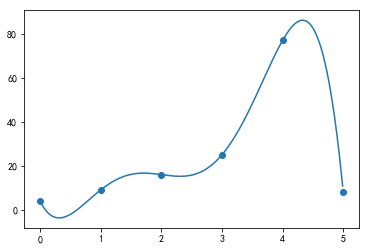

In [34]:
plt.scatter(x, y)
plt.plot(tmp_x, f(tmp_x))

In [35]:
inputfile = './data/data_6/missing_data.xls'
outputfile = './data/data_6/missing_data_processed.xls'

data = pd.read_excel(inputfile, header=None)
print('填充缺失值前：')
data.head()

填充缺失值前：


,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN


In [36]:
def polyinterp_column(s, n, k=5):
    y = s.reindex(list(range(n-k, n)) + list(range(n+1, n+1+k)))
    y = y[y.notnull()]
    return lagrange(y.index, list(y))(n)

for i in data.columns:
    for j in range(len(data)):
        if data.isnull().iloc[j, i]:
            data.iloc[j, i] = polyinterp_column(data[i], j)

print('填充缺失值后：')
data.head()

填充缺失值后：


,0,1,2
0,235.8333,324.034300,478.323100
1,236.2708,325.637900,515.456400
2,238.0521,328.089700,517.090900
3,235.9063,203.462116,514.890000
4,236.7604,268.832400,493.352591


In [37]:
data.to_excel(outputfile, header=None, index=False)

数据变换
- 通过电力计量系统采集的电量、电荷数据虽然在一定程度上能够反映窃漏电行为的特征，但是不够明显
- 利用数据变换，我们可以创建新的评价指标来凸显数据的规律
- 电量趋势下降指标：考虑前后几天作为统计窗口期，考虑期间的下降趋势，利用电量做直线拟合所得的斜率作为下降趋势的度量
- 线损指标：用于衡量用电线路的损失比例，若用户发生窃漏电，则当天的线损率会上升。但由于线损率有一些日常波动，考虑用前后几天的线损率平均值作为指标
- 对统计当天设定前后5天作为统计窗口期，分别统计当天与前五天、当天与后五天的线损率平均值，如果两者差别大于1%，则认为具有一定的窃漏电嫌疑
- 告警类指标：与窃漏电相关的终端报警主要有电压缺相、电压断相、电流反极性等告警，计算发生与窃漏电相关的终端报警次数的总和，作为告警类指标

**预处理后的数据**

In [38]:
datafile = './data/data_6/model.xls'
data = pd.read_excel(datafile)
data.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
0,4,1,1,1
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


### 模型构建

常见的分类预测模型有LM神经网络和CART决策树，构建这两个模型，从中选择最优的模型

In [39]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :3], data.iloc[:, 3], test_size=0.2, random_state=0, stratify=data.iloc[:, 3])

print('train set size: {}'.format(X_train.shape[0]))
print('test set size: {}'.format(X_test.shape[0]))

train set size: 232
test set size: 59


In [40]:
def cm_plot(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, linewidths=0.2, cmap='gray', annot=True, fmt='d', annot_kws={'size': 18},
                xticklabels=[0, 1], yticklabels=[0, 1])

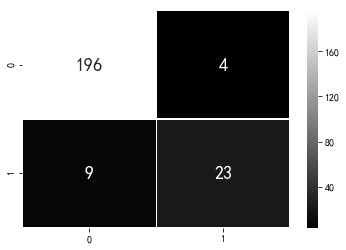

In [41]:
# 构建LM神经网络模型
from keras.models import Sequential
from keras.layers.core import Dense, Activation

netfile = './data/data_6/net.model'

net = Sequential()
net.add(Dense(10, input_shape=(3, )))
net.add(Activation('relu'))
net.add(Dense(1))
net.add(Activation('sigmoid'))
net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
net.fit(X_train, y_train, batch_size=1, epochs=1000, verbose=0)

# 测试模型
cm_plot(y_train, net.predict_classes(X_train))

In [42]:
net.save_weights(netfile)

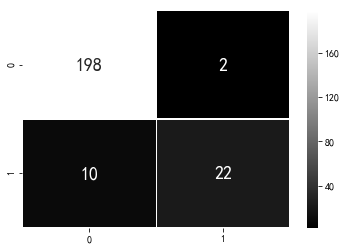

In [43]:
# 构建CART决策树模型
from sklearn.tree import DecisionTreeClassifier

treefile = './data/data_6/tree.pkl'
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

from sklearn.externals import joblib
joblib.dump(tree, treefile)

cm_plot(y_train, tree.predict(X_train))

**模型评价**

采用ROC曲线评价方法分别对LM神经网络和CART决策树模型进行评价

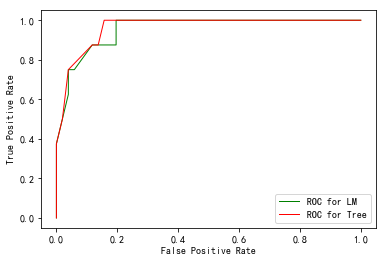

In [44]:
from sklearn.metrics import roc_curve

y_pred_proba_net = net.predict(X_test)
fpr_net, tpr_net, thresholds_net = roc_curve(y_test, y_pred_proba_net, pos_label=1)
y_pred_proba_tree = tree.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, threshold_tree = roc_curve(y_test, y_pred_proba_tree, pos_label=1)

plt.plot(fpr_net, tpr_net, 'g', linewidth=1, label='ROC for LM')
plt.plot(fpr_tree, tpr_tree, 'r', linewidth=1, label='ROC for Tree')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### 模型选择

经过对比发现，决策树模型的ROC曲线相对于LM神经网络的曲线更接近单位方形的左上角，总体而言表现更好。因此在这两个模型之中，选择决策树模型作为最终模型使用。